# Proposition 7: Comparative Statics for Riccati Equations and Limit Opinions

### Unified Model, Multiple Weighted Strategic Agents, Symmetric Network

James Yu, 4 July 2023

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
np.set_printoptions(suppress=True)

## Projected Solution Code

In [2]:
def eigensort(A):
    """Sort eigenvalues largest to smallest so the "1" comes first."""
    # the underlying process turns out to be a common implementation
    # regardless, partial inspiration for the underlying process from: 
    # https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
    # implementation reverse-engineered using the NumPy documentation
    eigvals_raw, U_raw = np.linalg.eig(A)
    eigval_sorting_map = np.flip(np.argsort(eigvals_raw)) 
    eigvals = eigvals_raw[eigval_sorting_map]
    U = U_raw[:, eigval_sorting_map]
    return eigvals, U

In [3]:
def tilde_Kj(c, delta, a1, a2, lambdaj):
    """Numerically solve the coupled Ricatti equations."""
    g1 = lambda x, y: x - (1 + (c*delta * lambdaj**2 * x * (delta*x*a1**2 + c))/((c+delta*x*a1**2 + delta*y*a2**2)**2))
    g2 = lambda x, y: y - (1 + (c*delta * lambdaj**2 * y * (delta*y*a2**2 + c))/((c+delta*x*a1**2 + delta*y*a2**2)**2))
    g = lambda x: [g1(x[0], x[1]), g2(x[0], x[1])]
    res = fsolve(g, [0, 0])
    if np.allclose(res, [0, 0]):
        # using [0, 0] as the initial point allows stronger distinction
        # between solver failure and correct-but-small solutions, since x, y > 1.
        raise Exception(f"fsolve failed to initialize: c = {c}, delta = {delta}, alpha1 = {a1}, alpha2 = {a2}, lambdaj = {lambdaj}")
    if not np.allclose(g(res), [0, 0]):
        # detects if solution isn't actually the solution
        raise Exception(f"fsolve failed to solve: c = {c}, delta = {delta}, alpha1 = {a1}, alpha2 = {a2}, lambdaj = {lambdaj}: {g(res)} != [0, 0]")
    return res

In [4]:
def solve(A, delta, c, a1, a2, b1, b2):
    """Solve for the optimal solution matrices and vectors."""
    eigvals, U = eigensort(A)
    D = np.diag(eigvals)
    n = len(eigvals)
    
    tilde_b1 = U.T @ (b1 * np.ones((n, 1)))
    tilde_b2 = U.T @ (b2 * np.ones((n, 1)))
    
    tilde_K_constructor = [tilde_Kj(c, delta, a1, a2, lambdaj) for lambdaj in eigvals]
    tilde_K1 = np.diag([K[0] for K in tilde_K_constructor])
    tilde_K2 = np.diag([K[1] for K in tilde_K_constructor])
    
    I = np.identity(n)
    Gamma = np.linalg.inv(c*I + delta*a1**2 * tilde_K1 + delta*a2**2 * tilde_K2)
    Y = I - delta * Gamma @ Gamma @ D @ (delta * a1**2 * tilde_K1 + c*I) @ (delta * a2**2 * tilde_K2 + c*I)
    Z1 = delta**2 * a2**2 * Gamma @ D @ (delta * a1**2 * tilde_K1 + c*I) @ tilde_K1 @ Gamma
    Z2 = delta**2 * a1**2 * Gamma @ D @ (delta * a2**2 * tilde_K2 + c*I) @ tilde_K2 @ Gamma
    
    tilde_Kk1 = np.linalg.inv(Y @ Y - Z1 @ Z2) @ (Y @ tilde_b1 - Z1 @ tilde_b2)
    tilde_Kk2 = np.linalg.inv(Y @ Y - Z1 @ Z2) @ (Y @ tilde_b2 - Z2 @ tilde_b1)
    
    return tilde_K1, tilde_K2, tilde_Kk1, tilde_Kk2

## 0. Sanity check on new code

In [5]:
A1 = np.array([
    [0.3, 0.5, 0.2],
    [0.5, 0.4, 0.1],
    [0.2, 0.1, 0.7]
])

In [6]:
def tilde_x_infty(A, delta, c, a1, a2, b1, b2):
    """Compute limit opinions."""
    tilde_K1, tilde_K2, tilde_Kk1, tilde_Kk2 = solve(A, delta, c, a1, a2, b1, b2)
    w = a1**2 * tilde_Kk1 + a2**2 * tilde_Kk2
    return np.linalg.inv(a1**2 * tilde_K1 + a2**2 * tilde_K2) @ w

In [7]:
tilde_x_infty(A1, 0.9, 1, 6, 5, 10, -10)

array([[-5.54201947],
       [ 0.        ],
       [ 0.        ]])

In [8]:
solve(A1, 0.9, 1, 6, 5, 10, -10) # returns K1, K2, K1k1, K2k2 in order

(array([[1.00964258, 0.        , 0.        ],
        [0.        , 1.00302499, 0.        ],
        [0.        , 0.        , 1.00024799]]),
 array([[1.00674558, 0.        , 0.        ],
        [0.        , 1.00212454, 0.        ],
        [0.        , 0.        , 1.00017446]]),
 array([[-31.10691353],
        [  0.        ],
        [  0.        ]]),
 array([[31.15709111],
        [-0.        ],
        [-0.        ]]))

These should match their respective printouts in the original Proposition 7 notebook.

## 1. Comparative statics on the limit opinions

In [9]:
def opinion_plot(x_grid, y_grid, agent, xlabel):
    plt.plot(x_grid, [y[agent-1] for y in y_grid], label = f"Agent {agent}")
    plt.xlabel(xlabel)
    plt.ylabel(r"$\tilde{x}_\infty$")
    plt.legend()
    plt.title(f"Limit Opinions vs {xlabel}")
    plt.show()

### 1a. Vary $c$

In [10]:
def ensemble_1a(A, delta, a1, a2, b1, b2, agent, c_grid):
    x_infty_grid = [tilde_x_infty(A, delta, c, a1, a2, b1, b2) for c in c_grid]
    opinion_plot(c_grid, x_infty_grid, agent, "$c$")

Only the first entry of the limit opinions is nonzero:

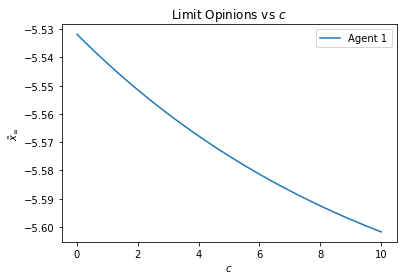

In [11]:
ensemble_1a(A = A1, delta = 0.9, a1 = 6, a2 = 5, b1 = 10, b2 = -10, agent = 1, c_grid = np.linspace(0.01, 10, 100))

However, due to numerical imprecision, we do still see some slight movement in the other two entries:

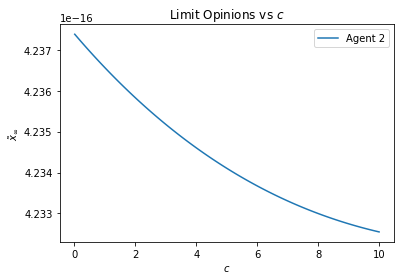

In [12]:
ensemble_1a(A = A1, delta = 0.9, a1 = 6, a2 = 5, b1 = 10, b2 = -10, agent = 2, c_grid = np.linspace(0.01, 10, 100))

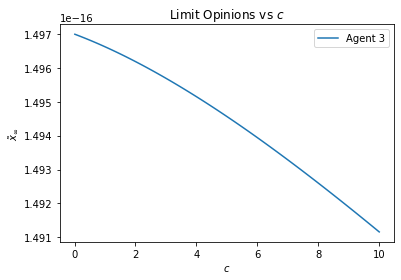

In [13]:
ensemble_1a(A = A1, delta = 0.9, a1 = 6, a2 = 5, b1 = 10, b2 = -10, agent = 3, c_grid = np.linspace(0.01, 10, 100))

But note the scaling factor in the top left corner: "1e-16". This means that the vertical axis scale must be multiplied by a factor of $10^{-16}$, which is indistinguishable from numerical errors.

Briefly, let's interpret the first graph (agent 1): the projected limit opinion is decreasing (increasing in magnitude) in message cost $c$. Since this is projected, the interpretation may be different for the original limit opinions:

In [14]:
def ensemble_1a_unprojected(A, delta, a1, a2, b1, b2, agent, c_grid):
    eigvals, U = eigensort(A)
    x_infty_grid = [U @ tilde_x_infty(A, delta, c, a1, a2, b1, b2) for c in c_grid]
    opinion_plot(c_grid, x_infty_grid, agent, "$c$")

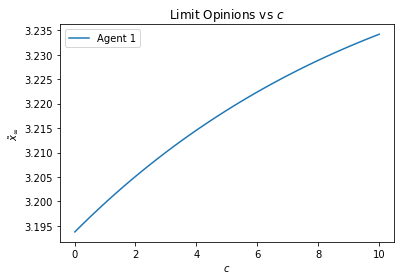

In [15]:
ensemble_1a_unprojected(A = A1, delta = 0.9, a1 = 6, a2 = 5, b1 = 10, b2 = -10, agent = 1, c_grid = np.linspace(0.01, 10, 100))

We see the same properties (magnitude increasing, diminishing effects as $c$ increases). Recall the unprojected opinions have consensus, so this will be the same for all agents.

Before we draw any conclusions, let's increase the search space:

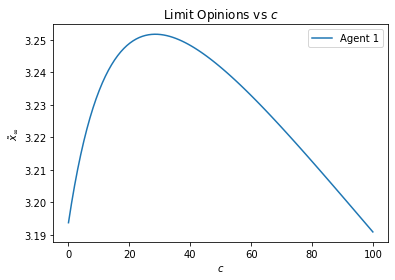

In [16]:
ensemble_1a_unprojected(A = A1, delta = 0.9, a1 = 6, a2 = 5, b1 = 10, b2 = -10, agent = 1, c_grid = np.linspace(0.01, 100, 100))

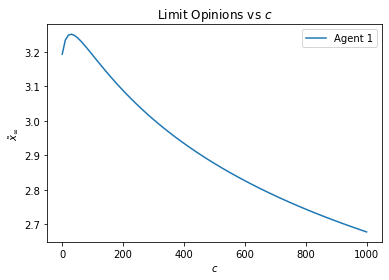

In [17]:
ensemble_1a_unprojected(A = A1, delta = 0.9, a1 = 6, a2 = 5, b1 = 10, b2 = -10, agent = 1, c_grid = np.linspace(0.01, 1000, 100))

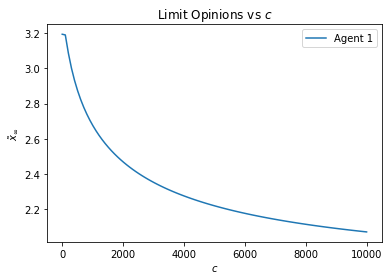

In [18]:
ensemble_1a_unprojected(A = A1, delta = 0.9, a1 = 6, a2 = 5, b1 = 10, b2 = -10, agent = 1, c_grid = np.linspace(0.01, 10000, 100))

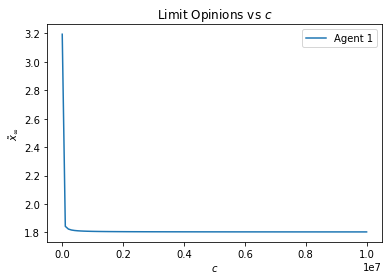

In [19]:
ensemble_1a_unprojected(A = A1, delta = 0.9, a1 = 6, a2 = 5, b1 = 10, b2 = -10, agent = 1, c_grid = np.linspace(0.01, 10000000, 100))

The initial increase could be explained by strategic agent 1's advantage over strategic agent 2 in terms of influence, given the limit opinions are approaching her agenda of 10. The later decrease could be explained by the increasing costliness of influence for both strategic agents.

To test the first theory, we can try to swap the agendas:

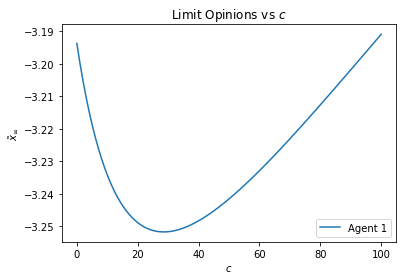

In [20]:
ensemble_1a_unprojected(A = A1, delta = 0.9, a1 = 6, a2 = 5, b1 = -10, b2 = 10, agent = 1, c_grid = np.linspace(0.01, 100, 100))

Indeed we see a direct symmetry compared to the earlier graph on this interval. If instead the agendas are close by:

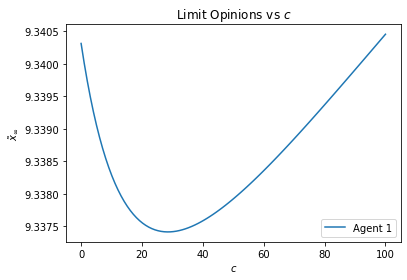

In [21]:
ensemble_1a_unprojected(A = A1, delta = 0.9, a1 = 6, a2 = 5, b1 = 9, b2 = 10, agent = 1, c_grid = np.linspace(0.01, 100, 100))

We still see the opinions initially moving towards the agenda of the first strategic agent, in agreement with the other results.

One question that would explain the second theory is what the limit opinions look like as $c$ goes to infinity:

In [22]:
eigvals1, U1 = eigensort(A1)
U1 @ tilde_x_infty(A = A1, delta = 0.9, c = 10000000000000, a1 = 6, a2 = 5, b1 = 9, b2 = 10)

array([[9.40983607],
       [9.40983607],
       [9.40983607]])

In [23]:
U1 @ tilde_x_infty(A = A1, delta = 0.9, c = 10000000000000, a1 = 5.5, a2 = 5, b1 = 9, b2 = 10)

array([[9.45248869],
       [9.45248869],
       [9.45248869]])

For the baseline where both strategic agents have equal influence:

In [24]:
U1 @ tilde_x_infty(A = A1, delta = 0.9, c = 10000000000000, a1 = 5, a2 = 5, b1 = 9, b2 = 10)

array([[9.5],
       [9.5],
       [9.5]])

which is actually $c$-independent:

In [25]:
U1 @ tilde_x_infty(A = A1, delta = 0.9, c = 0.1, a1 = 5, a2 = 5, b1 = 9, b2 = 10)

array([[9.5],
       [9.5],
       [9.5]])

So while the absolute influence levels are diminished by the high cost, the relative influence still has an impact on the limit opinions. It is not the case that the cost "drowns out" the effect of the differing influence weights. However, it is not immediately obvious where the exact values arise from, and thus not immediately obvious what the limit as $c$ goes to infinity of the limit opinions will be. What is obvious is that it will be a skew, in favour of the strategic agent with the higher weight, from the average of the two agendas.

### 1b. Vary $\delta$

In [26]:
def ensemble_1b(A, c, a1, a2, b1, b2, agent, delta_grid):
    x_infty_grid = [tilde_x_infty(A, delta, c, a1, a2, b1, b2) for delta in delta_grid]
    opinion_plot(delta_grid, x_infty_grid, agent, "$\delta$")

In [27]:
def ensemble_1b_unprojected(A, c, a1, a2, b1, b2, agent, delta_grid):
    eigvals, U = eigensort(A)
    x_infty_grid = [U @ tilde_x_infty(A, delta, c, a1, a2, b1, b2) for delta in delta_grid]
    opinion_plot(delta_grid, x_infty_grid, agent, "$\delta$")

First, projected:

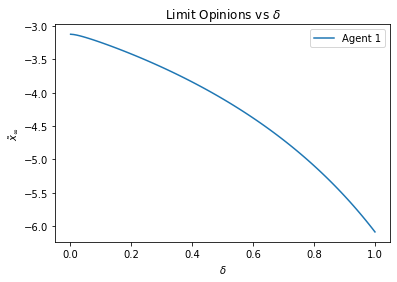

In [28]:
ensemble_1b(A = A1, c = 2.0, a1 = 6, a2 = 5, b1 = 10, b2 = -10, agent = 1, delta_grid = np.linspace(0.001, 0.999, 100))

Next, unprojected:

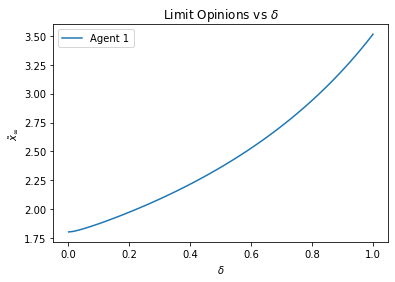

In [29]:
ensemble_1b_unprojected(A = A1, c = 2.0, a1 = 6, a2 = 5, b1 = 10, b2 = -10, agent = 1, delta_grid = np.linspace(0.001, 0.999, 100))

Here we can see the magnitude of the opinions increases with $\delta$ with increasing marginal effects. To benchmark, let's try adjusting the agendas:

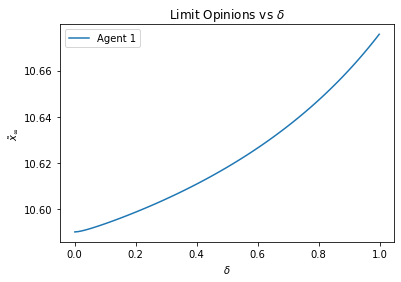

In [30]:
ensemble_1b_unprojected(A = A1, c = 2.0, a1 = 6, a2 = 5, b1 = 11, b2 = 10, agent = 1, delta_grid = np.linspace(0.001, 0.999, 100))

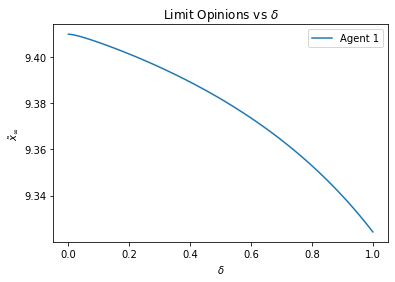

In [31]:
ensemble_1b_unprojected(A = A1, c = 2.0, a1 = 6, a2 = 5, b1 = 9, b2 = 10, agent = 1, delta_grid = np.linspace(0.001, 0.999, 100))

In progress...